# 모듈 임포트

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00


In [139]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드(삼성전자)

In [140]:
import yfinance as yf

# 삼성전자 종목코드: 005930
df = yf.download('005930.KS', start = '2022-01-01', end = '2022-06-01')

[*********************100%%**********************]  1 of 1 completed


In [141]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,75235.234375,12427416
2022-01-05,78800.0,79000.0,76400.0,77400.0,73992.453125,25470640
2022-01-06,76700.0,77600.0,76600.0,76900.0,73514.476562,12931954
2022-01-07,78100.0,78400.0,77400.0,78300.0,74852.835938,15163757
2022-01-10,78100.0,78100.0,77100.0,78000.0,74566.039062,9947422


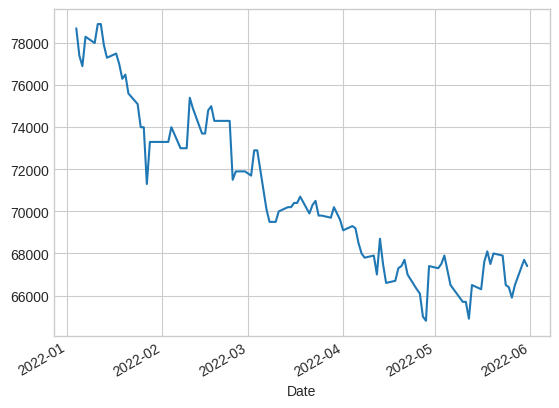

In [142]:
# 예측 대상이 종가이므로 종가 시각화
fig = df['Close'].plot()

# Decomposition



*  Trend: 데이터가 장기적으로 증가하거나 감소하는 것
*  Seasonal: 데이터의 명확하고 일정한 패턴. 일정한 빈도를 가짐.
*  Cycle: 고정된 빈도가 아닌 형태로 증가하거나 감소하는 모습을 보일 때 나타남.



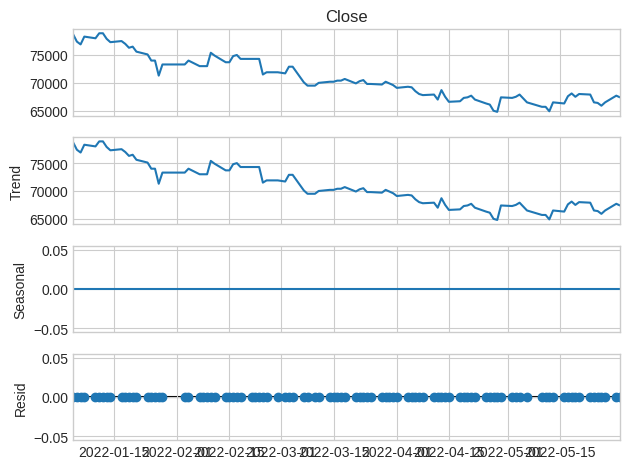

In [143]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df['Close'], model = 'additive', period = 1)
fig = decomposition.plot()
plt.show()

# ACF, PACF

*   ACF: t시점과 t시점에서 k만큼 떨어진 t+k시점 사이의 상관계수를 구하는 함수
*   PACF: 구하고 싶은 것에 영향을미치는 요인들 중에서 확인하고자 하는 요안 아외의 것들의 영향력을 제외하고 상관관계를 구하는 것




In [144]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size = 0.2, shuffle = False)

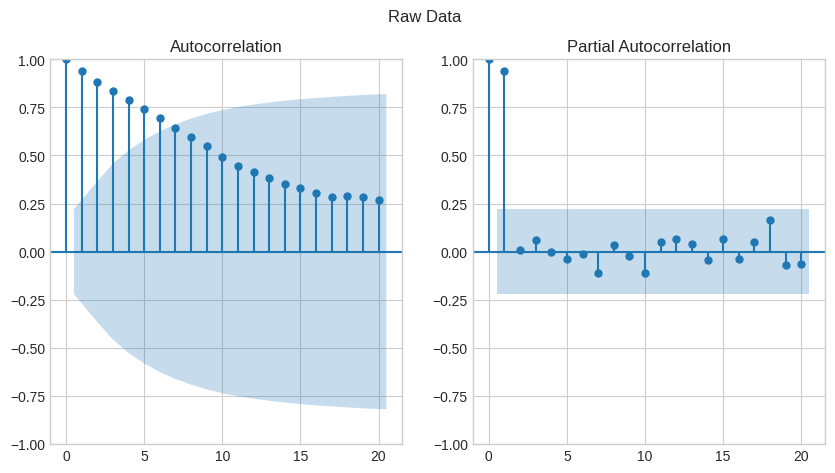

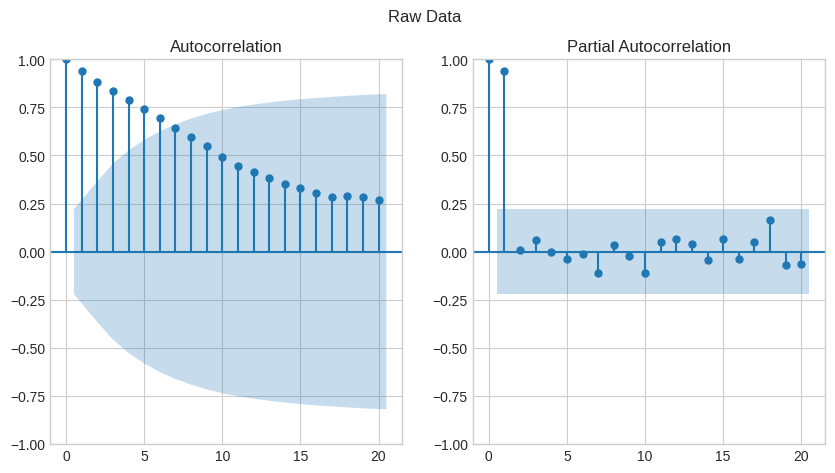

In [145]:
# ACF, PACF 시각화
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

# Differencing

*   ACF가 감소하는 패턴 -> non-stationary
*   차분 진행.




In [146]:
# non-stationary -> stationary 보정 (differencing)
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거

star = '*'
print(f'{star*15}Raw Data{star*15}')
print(train_data['Close'].head())
print(f'{star*15}Differenced Data{star*15}')
print(diff_train_data.head())

***************Raw Data***************
Date
2022-01-04    78700.0
2022-01-05    77400.0
2022-01-06    76900.0
2022-01-07    78300.0
2022-01-10    78000.0
Name: Close, dtype: float64
***************Differenced Data***************
Date
2022-01-05   -1300.0
2022-01-06    -500.0
2022-01-07    1400.0
2022-01-10    -300.0
2022-01-11     900.0
Name: Close, dtype: float64


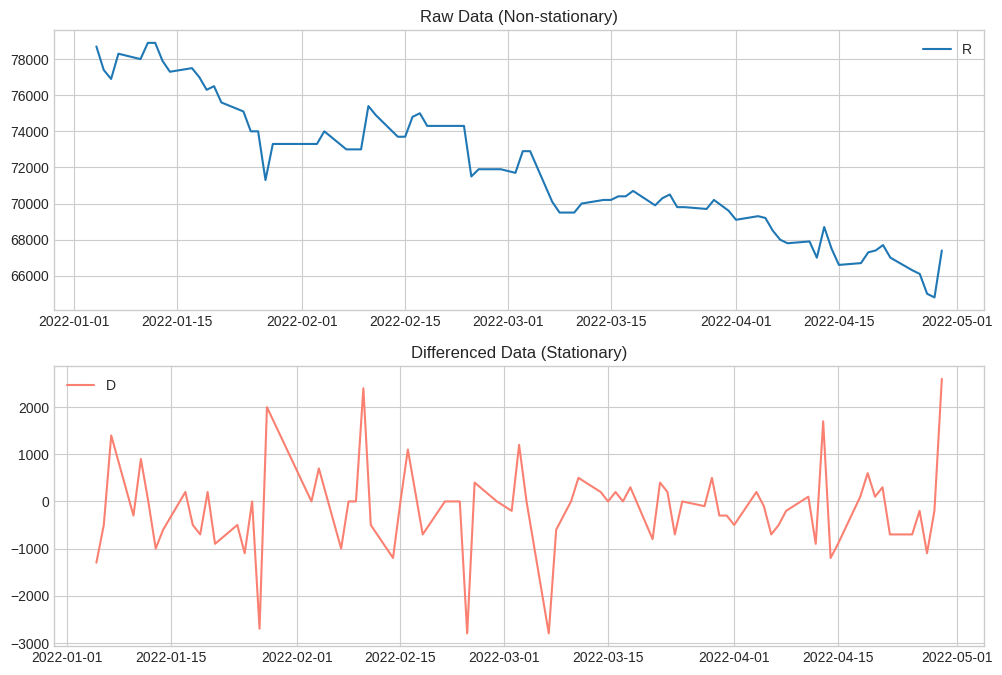

In [147]:
# 차분 전, 후 시각화
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw Data (Non-stationary)')
ax1.set_title('Raw Data (Non-stationary)')

ax2.plot(diff_train_data, color = 'salmon')
ax2.legend('Differenced Data (Stationary)')
ax2.set_title('Differenced Data (Stationary)')

plt.show()

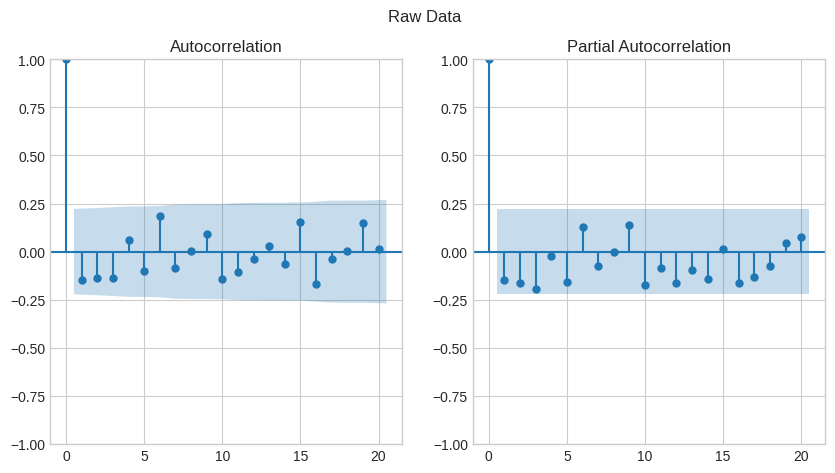

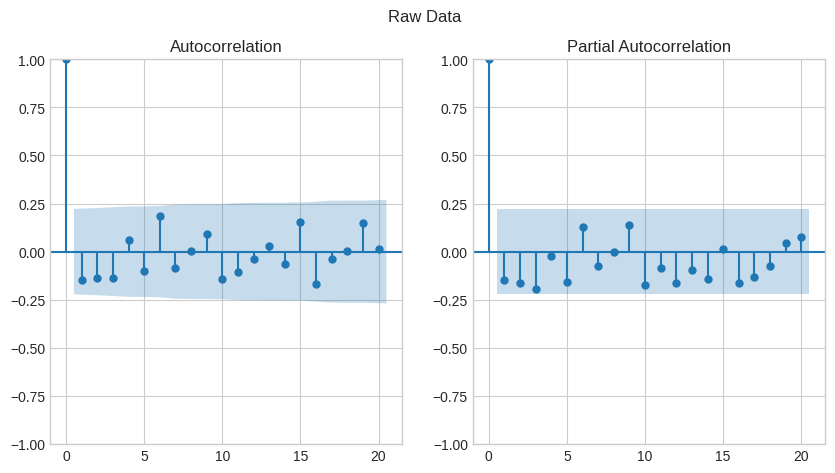

In [148]:
# 차분 후 ACF, PACF 시각화
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

#모델


### 1. ARIMA

In [97]:
!pip install statsmodels

In [164]:
from statsmodels.tsa.arima.model import ARIMA

# 최적의 파라미터 탐색
p = range(0, 2)
d = range(1, 3)
q = range(0, 2)
pdq = list(itertools.product(p,d, q))

# AIC: 모델의 적합도와 모델의 복잡도를 고려하여 모델을 선택하는 데 사용되는 지표
#      일반적으로 AIC가 가장 낮은 모델이 데이터에 가장 적합
AIC = []
for i in pdq:
  model = ARIMA(train_data['Close'].values, order = (i))
  model_fit = model.fit()
  print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
  AIC.append(round(model_fit.aic, 2))

ARIMA pdq : (0, 1, 0) >> AIC : 1289.84
ARIMA pdq : (0, 1, 1) >> AIC : 1289.15
ARIMA pdq : (0, 2, 0) >> AIC : 1331.78
ARIMA pdq : (0, 2, 1) >> AIC : 1330.42
ARIMA pdq : (1, 1, 0) >> AIC : 1289.25
ARIMA pdq : (1, 1, 1) >> AIC : 1290.95
ARIMA pdq : (1, 2, 0) >> AIC : 1332.6
ARIMA pdq : (1, 2, 1) >> AIC : 1330.1


In [165]:
# optimal parameter 출력
optim = [(pdq[i], j) for i ,j in enumerate(AIC) if j == min(AIC)]
print('Optimal Parameter : ', optim)

Optimal Parameter :  [((0, 1, 1), 1289.15)]


In [166]:
model = ARIMA(train_data['Close'].values, order = (1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -642.474
Date:                Sat, 06 Apr 2024   AIC                           1290.949
Time:                        16:15:38   BIC                           1298.019
Sample:                             0   HQIC                          1293.779
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9781      0.031     31.608      0.000       0.917       1.039
ma.L1         -0.9913      0.031    -32.017      0.000      -1.052      -0.931
sigma2      8.217e+05    9.1e+04      9.029      0.000    6.43e+05       1e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):                16.16
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.03
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

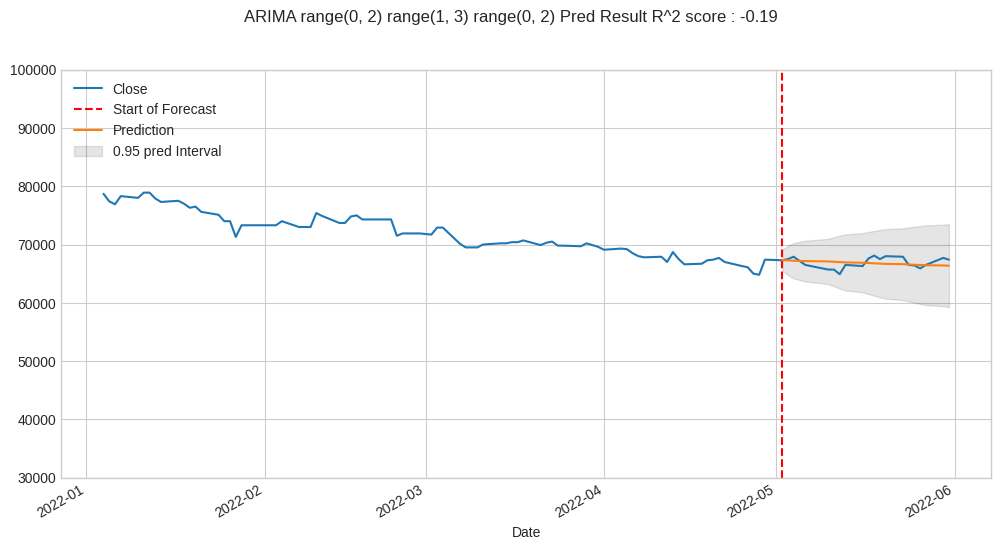

In [167]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax=ax)
ax.vlines('2022-05-02', 30000, 100000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.ylim(30000, 100000)
plt.suptitle(f'ARIMA {p} {d} {q} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

# 2. SARIMAX

In [149]:
# 최적의 파라미터 탐색
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq]

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try :
            model = SARIMAX(train_data['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))

        except Exception as e:
            print(e)
            continue

SARIMA : (0, 1, 0),(0, 1, 0, 3) >> AIC : 1296.56
SARIMA : (0, 1, 0),(0, 1, 1, 3) >> AIC : 1303.69
SARIMA : (0, 1, 0),(0, 1, 2, 3) >> AIC : 1299.85
SARIMA : (0, 1, 0),(1, 1, 0, 3) >> AIC : 1298.3
SARIMA : (0, 1, 0),(1, 1, 1, 3) >> AIC : 1299.54
SARIMA : (0, 1, 0),(1, 1, 2, 3) >> AIC : 1302.29
SARIMA : (0, 1, 0),(2, 1, 0, 3) >> AIC : 1299.86
SARIMA : (0, 1, 0),(2, 1, 1, 3) >> AIC : 1302.3
SARIMA : (0, 1, 0),(2, 1, 2, 3) >> AIC : 1299.37
SARIMA : (0, 1, 1),(0, 1, 0, 3) >> AIC : 1297.4
SARIMA : (0, 1, 1),(0, 1, 1, 3) >> AIC : 1299.16
SARIMA : (0, 1, 1),(0, 1, 2, 3) >> AIC : 1300.75
SARIMA : (0, 1, 1),(1, 1, 0, 3) >> AIC : 1299.17
SARIMA : (0, 1, 1),(1, 1, 1, 3) >> AIC : 1300.45
SARIMA : (0, 1, 1),(1, 1, 2, 3) >> AIC : 1302.4
SARIMA : (0, 1, 1),(2, 1, 0, 3) >> AIC : 1300.76
SARIMA : (0, 1, 1),(2, 1, 1, 3) >> AIC : 1302.4
SARIMA : (0, 1, 1),(2, 1, 2, 3) >> AIC : 1298.54
SARIMA : (0, 1, 2),(0, 1, 0, 3) >> AIC : 1298.53
SARIMA : (0, 1, 2),(0, 1, 1, 3) >> AIC : 1300.38
SARIMA : (0, 1, 2),(0, 1,

In [150]:
# optimal parameter
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)

[(((2, 1, 2), (0, 1, 0, 3)), 1293.53)]


In [151]:
model = SARIMAX(train_data['Close'].values, order = optim[0][0][0], seasonal_oorder = optim[0][0][1])
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -639.245
Date:                Sat, 06 Apr 2024   AIC                           1288.489
Time:                        16:07:40   BIC                           1300.273
Sample:                             0   HQIC                          1293.207
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9944      0.036    -27.680      0.000      -1.065      -0.924
ar.L2         -0.9980      0.023    -44.331      0.000      -1.042      -0.954
ma.L1          0.9885      0.060     16.402      0.000       0.870       1.107
ma.L2          0.9970      0.094     10.632      0.000       0.813       1.181
sigma2      8.334e+05   6.26e-08   1.33e+13      0.000    8.33e+05    8.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 6.56
Prob(Q):                              0.31   Prob(JB):                         0.04
Heteroskedasticity (H):               0.55   Skew:                            -0.09
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.05e+28. Standard errors may be unstable.
"""

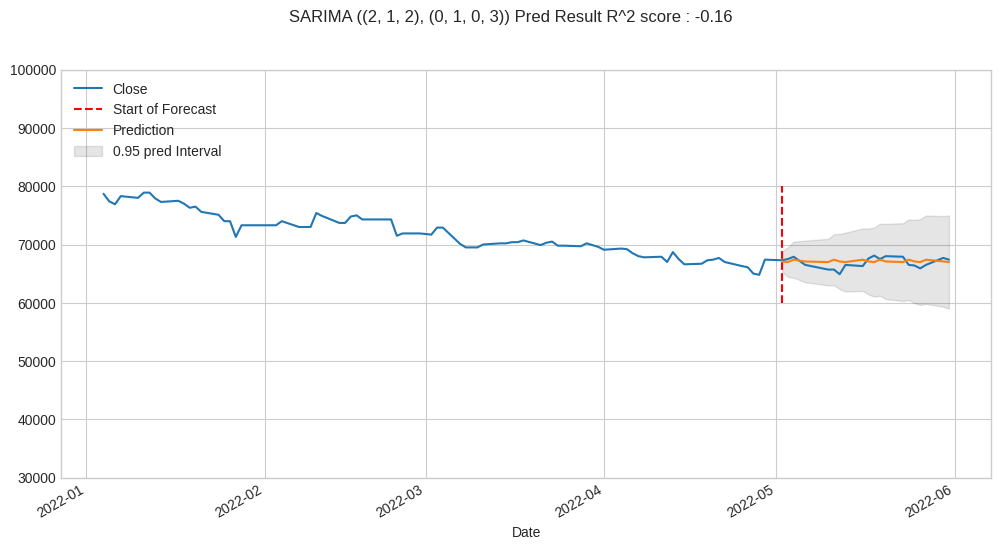

In [162]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-05-02', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.ylim(30000, 100000)
plt.suptitle(f'SARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

# auto ARIMA

In [156]:
auto_arima_model = auto_arima(train_data['Close'], start_p=1, start_q=1,
                             max_p=3, max_1=3, m=3, seasonal=True, # sarima(seasonal=True)
                             d=1, D=1,
                             max_P=3, max_Q=3,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,1,0)[3]             : AIC=1296.557, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=1303.687, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[3]             : AIC=1299.850, Time=0.41 sec
 ARIMA(0,1,0)(0,1,3)[3]             : AIC=1301.719, Time=1.31 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=1298.303, Time=0.38 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=1299.536, Time=0.56 sec
 ARIMA(0,1,0)(1,1,2)[3]             : AIC=inf, Time=1.17 sec
 ARIMA(0,1,0)(1,1,3)[3]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=1299.862, Time=0.35 sec
 ARIMA(0,1,0)(2,1,1)[3]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(2,1,2)[3]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(2,1,3)[3]             : AIC=inf, Time=2.43 sec
 ARIMA(0,1,0)(3,1,0)[3]             : AIC=1301.758, Time=0.84 sec
 ARIMA(0,1,0)(3,1,1)[3]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(3,1,2)[3]             : AIC=inf, Time=2.89 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=129

In [ ]:
auto_arima_model.summary()

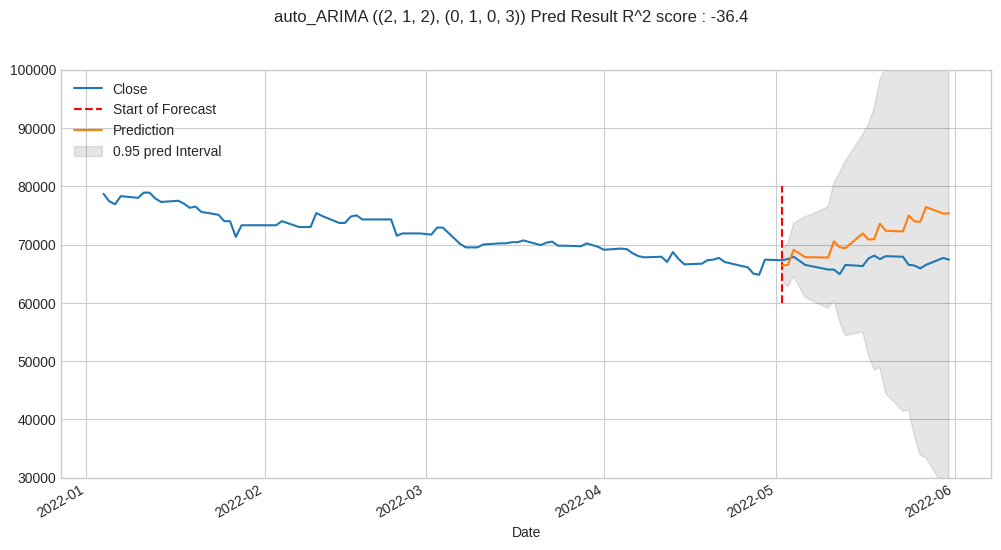

In [161]:
pred = auto_arima_model.predict(len(test_data), return_conf_int = True)
pred_val = pred[0]
pred_ub = pred[1][:, 0]
pred_lb = pred[1][:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-05-02', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.ylim(30000, 100000)
plt.suptitle(f'auto_ARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()